Epoch 1/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:44<00:00,  1.10s/it, loss=0.644]


Epoch 1/30, Loss: 0.64407384104845
Validation Accuracy: 76.01246105919003%


Epoch 2/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:31<00:00,  1.30it/s, loss=0.525]


Epoch 2/30, Loss: 0.5251805142658513
Validation Accuracy: 77.57009345794393%


Epoch 3/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:29<00:00,  1.38it/s, loss=0.448]


Epoch 3/30, Loss: 0.44763345107799624
Validation Accuracy: 77.25856697819314%


Epoch 4/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:28<00:00,  1.46it/s, loss=0.424]


Epoch 4/30, Loss: 0.42420146450763796
Validation Accuracy: 76.32398753894081%


Epoch 5/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:27<00:00,  1.51it/s, loss=0.378]


Epoch 5/30, Loss: 0.37761402493569907
Validation Accuracy: 77.57009345794393%


Epoch 6/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:27<00:00,  1.51it/s, loss=0.359]


Epoch 6/30, Loss: 0.3585770293706801
Validation Accuracy: 72.89719626168224%


Epoch 7/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:27<00:00,  1.50it/s, loss=0.334]


Epoch 7/30, Loss: 0.334016204243753
Validation Accuracy: 74.76635514018692%
Early stopping 적용


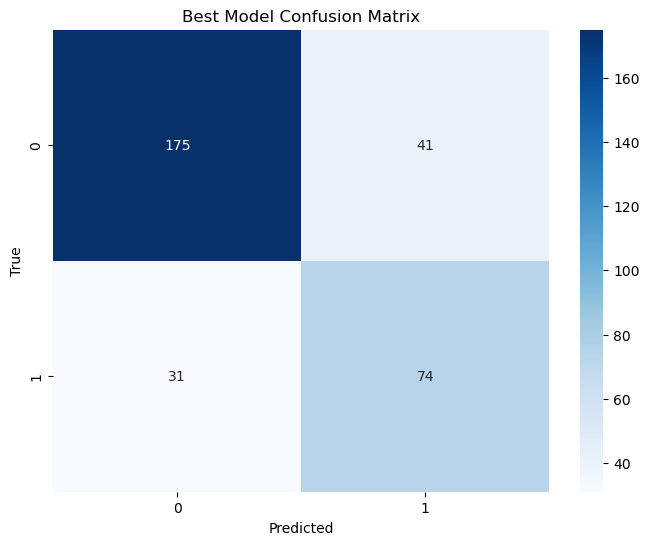

In [1]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm  # TQDM import
import torch.nn as nn
from collections import Counter
from sklearn.metrics import confusion_matrix  # 혼동 행렬을 위한 import
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []
        
        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

# 경로 및 배치 크기 설정
data_dir = "."
batch_size = 64

# 데이터 증강 포함한 이미지 전처리
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),  # 더 큰 회전 각도
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이미지 이동
    T.GaussianBlur(kernel_size=3),  # Gaussian Blur 추가
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 학습 및 검증 데이터셋 생성
train_dataset = CustomDataset(os.path.join(data_dir, 'train'), transform=transform)
valid_dataset = CustomDataset(os.path.join(data_dir, 'valid'), transform=transform)

# 각 클래스의 데이터 개수 계산 (Counter 사용)
class_counts = Counter([label for _, label in train_dataset])

# 클래스별로 가중치를 부여 (데이터 개수의 역수 사용)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# 각 샘플의 가중치를 리스트로 변환
sample_weights = [class_weights[label] for _, label in train_dataset]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

# WeightedRandomSampler를 적용한 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 사전 학습된 resnext50_32x4d 모델 사용
from torchvision.models import ResNeXt50_32X4D_Weights

weights = ResNeXt50_32X4D_Weights.DEFAULT
model = models.resnext50_32x4d(weights=weights)

# 모든 레이어 학습 가능하도록 설정 (전이 학습 제외)
for param in model.parameters():
    param.requires_grad = True

# 출력 레이어를 분류하려는 클래스 수에 맞게 수정 (드롭아웃 비율 0.5로 설정)
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout 비율을 0.5로 증가
    nn.Linear(model.fc.in_features, len(train_dataset.classes))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping 설정
best_accuracy = 0
best_cm = None  # 베스트 모델일 때 혼동 행렬 저장
patience = 5  # 개선되지 않는 에포크를 허용하는 최대 수
counter = 0

# 손실 함수 및 AdamW 옵티마이저 설정 (학습률 0.00005로 감소, 가중치 감쇠 0.1로 증가)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

# 학습률 스케줄러 추가 (학습률 점진적 감소, gamma=0.5, step_size=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 과정 (TQDM으로 진행 상황 시각화, 에포크 30)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # TQDM으로 학습 진행 표시
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in train_loader_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader_iter.set_postfix(loss=running_loss / len(train_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 평가
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())  # 실제 라벨 저장
            all_preds.extend(predicted.cpu().numpy())  # 예측 라벨 저장

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy}%')

    # Early Stopping 기준
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        counter = 0  # 성능 개선 시 카운터 초기화
        torch.save(model.state_dict(), 'best_model.pth')  # 최적의 모델 저장

        # 베스트 모델일 때 혼동 행렬 계산 및 저장
        best_cm = confusion_matrix(all_labels, all_preds)

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping 적용")
            break

# 베스트 모델의 혼동 행렬 시각화
if best_cm is not None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Best Model Confusion Matrix')
    plt.show()


## ResNet 이용

Epoch 1/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.76it/s, loss=0.617]


Epoch 1/30, Loss: 0.6165396752880841
Validation Accuracy: 74.76635514018692%


Epoch 2/30: 100%|███████████████████████████████████████████████████████████| 41/41 [00:15<00:00,  2.60it/s, loss=0.49]


Epoch 2/30, Loss: 0.48998185338043587
Validation Accuracy: 69.78193146417445%


Epoch 3/30: 100%|███████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.76it/s, loss=0.42]


Epoch 3/30, Loss: 0.4195900501274481
Validation Accuracy: 64.797507788162%


Epoch 4/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.82it/s, loss=0.365]


Epoch 4/30, Loss: 0.36519571884376245
Validation Accuracy: 77.25856697819314%


Epoch 5/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:15<00:00,  2.63it/s, loss=0.342]


Epoch 5/30, Loss: 0.3416657316975477
Validation Accuracy: 75.0778816199377%


Epoch 6/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.84it/s, loss=0.314]


Epoch 6/30, Loss: 0.31413243347551767
Validation Accuracy: 70.40498442367601%


Epoch 7/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.79it/s, loss=0.263]


Epoch 7/30, Loss: 0.2634535337366709
Validation Accuracy: 77.88161993769471%


Epoch 8/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:15<00:00,  2.64it/s, loss=0.215]


Epoch 8/30, Loss: 0.2154035937131905
Validation Accuracy: 71.33956386292834%


Epoch 9/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.79it/s, loss=0.215]


Epoch 9/30, Loss: 0.21508330488350333
Validation Accuracy: 75.38940809968847%


Epoch 10/30: 100%|█████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.75it/s, loss=0.179]


Epoch 10/30, Loss: 0.1786824931822172
Validation Accuracy: 75.0778816199377%
Early stopping 적용


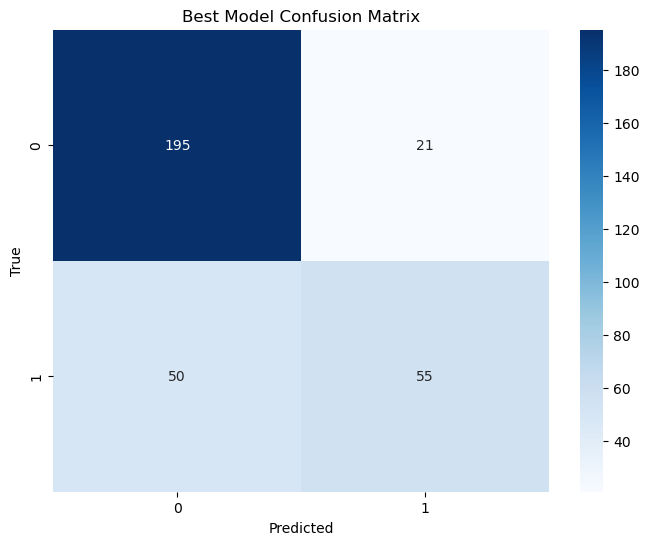

In [2]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm  # TQDM import
import torch.nn as nn
from collections import Counter
from sklearn.metrics import confusion_matrix  # 혼동 행렬을 위한 import
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []
        
        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

# 경로 및 배치 크기 설정
data_dir = "."
batch_size = 64

# 데이터 증강 포함한 이미지 전처리
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),  # 더 큰 회전 각도
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이미지 이동
    T.GaussianBlur(kernel_size=3),  # Gaussian Blur 추가
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 학습 및 검증 데이터셋 생성
train_dataset = CustomDataset(os.path.join(data_dir, 'train'), transform=transform)
valid_dataset = CustomDataset(os.path.join(data_dir, 'valid'), transform=transform)

# 각 클래스의 데이터 개수 계산 (Counter 사용)
class_counts = Counter([label for _, label in train_dataset])

# 클래스별로 가중치를 부여 (데이터 개수의 역수 사용)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# 각 샘플의 가중치를 리스트로 변환
sample_weights = [class_weights[label] for _, label in train_dataset]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

# WeightedRandomSampler를 적용한 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 사전 학습된 ResNet18 모델 사용
from torchvision.models import ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

# 모든 레이어 학습 가능하도록 설정 (전이 학습 제외)
for param in model.parameters():
    param.requires_grad = True

# 출력 레이어를 분류하려는 클래스 수에 맞게 수정 (드롭아웃 비율 0.5로 설정)
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout 비율을 0.5로 증가
    nn.Linear(model.fc.in_features, len(train_dataset.classes))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping 설정
best_accuracy = 0
best_cm = None  # 베스트 모델일 때 혼동 행렬 저장
patience = 3  # 개선되지 않는 에포크를 허용하는 최대 수
counter = 0

# 손실 함수 및 AdamW 옵티마이저 설정 (학습률 0.0001로 설정)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1)

# 학습률 스케줄러 추가 (학습률 점진적 감소, gamma=0.5, step_size=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 과정 (TQDM으로 진행 상황 시각화, 에포크 30)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # TQDM으로 학습 진행 표시
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in train_loader_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader_iter.set_postfix(loss=running_loss / len(train_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 평가
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())  # 실제 라벨 저장
            all_preds.extend(predicted.cpu().numpy())  # 예측 라벨 저장

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy}%')

    # Early Stopping 기준
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        counter = 0  # 성능 개선 시 카운터 초기화
        torch.save(model.state_dict(), 'best_model.pth')  # 최적의 모델 저장

        # 베스트 모델일 때 혼동 행렬 계산 및 저장
        best_cm = confusion_matrix(all_labels, all_preds)

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping 적용")
            break

# 베스트 모델의 혼동 행렬 시각화
if best_cm is not None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Best Model Confusion Matrix')
    plt.show()


Epoch 1/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.49it/s, loss=0.689]


Epoch 1/30, Loss: 0.6891584032919349
Validation Accuracy: 69.1588785046729%


Epoch 2/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.49it/s, loss=0.674]


Epoch 2/30, Loss: 0.6743151501911443
Validation Accuracy: 74.45482866043614%


Epoch 3/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.48it/s, loss=0.648]


Epoch 3/30, Loss: 0.648248990861381
Validation Accuracy: 74.45482866043614%


Epoch 4/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.51it/s, loss=0.635]


Epoch 4/30, Loss: 0.6347773176867787
Validation Accuracy: 75.0778816199377%


Epoch 5/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.47it/s, loss=0.611]


Epoch 5/30, Loss: 0.6105374882860881
Validation Accuracy: 75.0778816199377%


Epoch 6/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.52it/s, loss=0.595]


Epoch 6/30, Loss: 0.5945891207311211
Validation Accuracy: 72.89719626168224%


Epoch 7/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.50it/s, loss=0.574]


Epoch 7/30, Loss: 0.5742575497162051
Validation Accuracy: 73.20872274143302%


Epoch 8/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.51it/s, loss=0.572]


Epoch 8/30, Loss: 0.571542014436024
Validation Accuracy: 74.76635514018692%


Epoch 9/30: 100%|███████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.51it/s, loss=0.55]


Epoch 9/30, Loss: 0.5501999011853846
Validation Accuracy: 75.38940809968847%


Epoch 10/30: 100%|█████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.48it/s, loss=0.534]


Epoch 10/30, Loss: 0.5338234276306338
Validation Accuracy: 75.0778816199377%


Epoch 11/30: 100%|█████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.51it/s, loss=0.529]


Epoch 11/30, Loss: 0.528823279752964
Validation Accuracy: 73.20872274143302%


Epoch 12/30: 100%|█████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.52it/s, loss=0.513]


Epoch 12/30, Loss: 0.5129566745060247
Validation Accuracy: 73.5202492211838%


Epoch 13/30: 100%|█████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.50it/s, loss=0.521]


Epoch 13/30, Loss: 0.5208307788139437
Validation Accuracy: 75.70093457943925%


Epoch 14/30: 100%|█████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.48it/s, loss=0.515]


Epoch 14/30, Loss: 0.5147269927873844
Validation Accuracy: 75.0778816199377%


Epoch 15/30: 100%|█████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.52it/s, loss=0.509]


Epoch 15/30, Loss: 0.5093152544847349
Validation Accuracy: 73.20872274143302%


Epoch 16/30: 100%|██████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.53it/s, loss=0.51]


Epoch 16/30, Loss: 0.5100624888408475
Validation Accuracy: 75.38940809968847%


Epoch 17/30: 100%|█████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.52it/s, loss=0.504]


Epoch 17/30, Loss: 0.5041937181135503
Validation Accuracy: 75.38940809968847%


Epoch 18/30: 100%|███████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.52it/s, loss=0.5]


Epoch 18/30, Loss: 0.5003258048034296
Validation Accuracy: 73.5202492211838%
Early stopping 적용


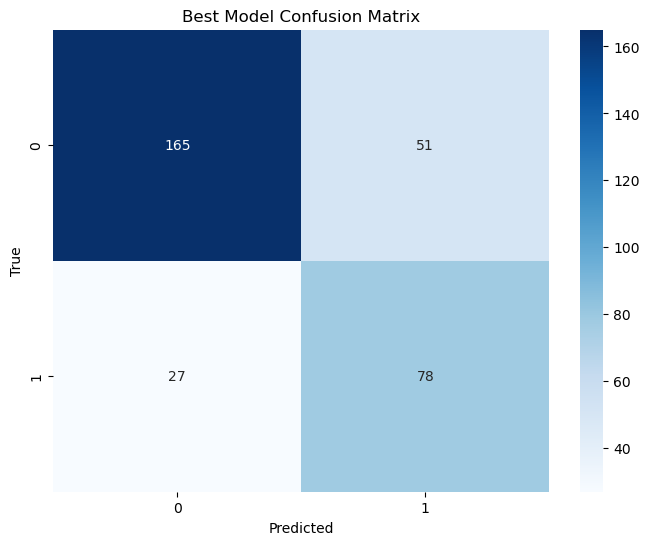

In [2]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm  # TQDM import
import torch.nn as nn
from collections import Counter
from sklearn.metrics import confusion_matrix  # 혼동 행렬을 위한 import
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []
        
        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

# 경로 및 배치 크기 설정
data_dir = "."
batch_size = 64

# 데이터 증강 포함한 이미지 전처리
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),  # 더 큰 회전 각도
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이미지 이동
    T.GaussianBlur(kernel_size=3),  # Gaussian Blur 추가
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 학습 및 검증 데이터셋 생성
train_dataset = CustomDataset(os.path.join(data_dir, 'train'), transform=transform)
valid_dataset = CustomDataset(os.path.join(data_dir, 'valid'), transform=transform)

# 각 클래스의 데이터 개수 계산 (Counter 사용)
class_counts = Counter([label for _, label in train_dataset])

# 클래스별로 가중치를 부여 (데이터 개수의 역수 사용)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# 각 샘플의 가중치를 리스트로 변환
sample_weights = [class_weights[label] for _, label in train_dataset]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

# WeightedRandomSampler를 적용한 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 사전 학습된 MobileNetV2 모델 사용
from torchvision.models import MobileNet_V2_Weights

weights = MobileNet_V2_Weights.DEFAULT
model = models.mobilenet_v2(weights=weights)

# 모든 레이어 학습 가능하도록 설정 (전이 학습 제외)
for param in model.parameters():
    param.requires_grad = True

# 출력 레이어를 분류하려는 클래스 수에 맞게 수정 (드롭아웃 비율 0.5로 설정)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Dropout 비율을 0.5로 증가
    nn.Linear(model.classifier[1].in_features, len(train_dataset.classes))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping 설정
best_accuracy = 0
best_cm = None  # 베스트 모델일 때 혼동 행렬 저장
patience = 5  # 개선되지 않는 에포크를 허용하는 최대 수
counter = 0

# 손실 함수 및 AdamW 옵티마이저 설정 (학습률 0.00005로 감소, 가중치 감쇠 0.1로 증가)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.1)

# 학습률 스케줄러 추가 (학습률 점진적 감소, gamma=0.5, step_size=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 과정 (TQDM으로 진행 상황 시각화, 에포크 30)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # TQDM으로 학습 진행 표시
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in train_loader_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader_iter.set_postfix(loss=running_loss / len(train_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 평가
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())  # 실제 라벨 저장
            all_preds.extend(predicted.cpu().numpy())  # 예측 라벨 저장

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy}%')

    # Early Stopping 기준
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        counter = 0  # 성능 개선 시 카운터 초기화
        torch.save(model.state_dict(), 'best_model.pth')  # 최적의 모델 저장

        # 베스트 모델일 때 혼동 행렬 계산 및 저장
        best_cm = confusion_matrix(all_labels, all_preds)

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping 적용")
            break

# 베스트 모델의 혼동 행렬 시각화
if best_cm is not None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Best Model Confusion Matrix')
    plt.show()


Epoch 1/30: 100%|██████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  4.78it/s, loss=0.696]


Epoch 1/30, Loss: 0.6961045640486258
Validation Accuracy: 55.45171339563863%


Epoch 2/30: 100%|██████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  4.81it/s, loss=0.667]


Epoch 2/30, Loss: 0.6669157434392858
Validation Accuracy: 67.601246105919%


Epoch 3/30: 100%|██████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  4.82it/s, loss=0.636]


Epoch 3/30, Loss: 0.635523428151637
Validation Accuracy: 71.65109034267913%


Epoch 4/30: 100%|██████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  4.90it/s, loss=0.616]


Epoch 4/30, Loss: 0.6156240385255696
Validation Accuracy: 72.58566978193146%


Epoch 5/30: 100%|██████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  4.93it/s, loss=0.583]


Epoch 5/30, Loss: 0.5830135054794359
Validation Accuracy: 72.27414330218069%


Epoch 6/30: 100%|██████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  5.01it/s, loss=0.545]


Epoch 6/30, Loss: 0.5450609079849573
Validation Accuracy: 75.38940809968847%


Epoch 7/30: 100%|███████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  4.84it/s, loss=0.54]


Epoch 7/30, Loss: 0.5395934982800189
Validation Accuracy: 76.94704049844236%


Epoch 8/30: 100%|██████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  4.94it/s, loss=0.509]


Epoch 8/30, Loss: 0.5092394366676425
Validation Accuracy: 72.27414330218069%


Epoch 9/30: 100%|██████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  4.93it/s, loss=0.513]


Epoch 9/30, Loss: 0.5129077265292038
Validation Accuracy: 74.14330218068535%


Epoch 10/30: 100%|█████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  4.90it/s, loss=0.503]


Epoch 10/30, Loss: 0.5031949668018906
Validation Accuracy: 74.76635514018692%


Epoch 11/30: 100%|█████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  4.93it/s, loss=0.496]


Epoch 11/30, Loss: 0.49638335977071596
Validation Accuracy: 75.70093457943925%


Epoch 12/30: 100%|██████████████████████████████████████████████████████████| 81/81 [00:16<00:00,  5.06it/s, loss=0.49]


Epoch 12/30, Loss: 0.4904880244054912
Validation Accuracy: 76.01246105919003%
Early stopping 적용


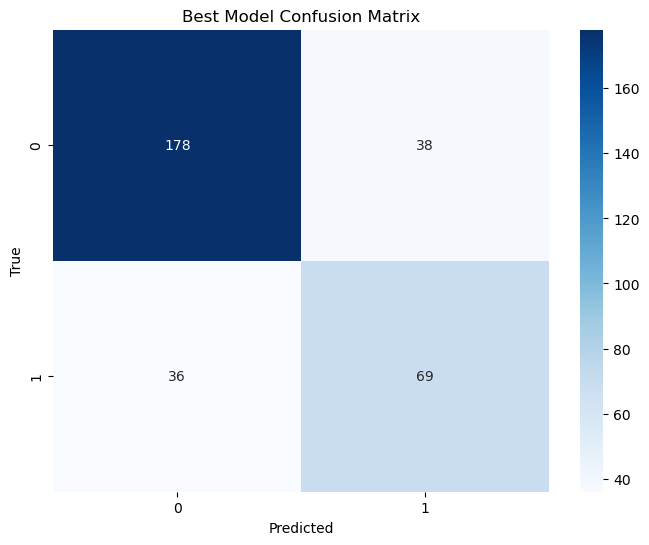

In [3]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm  # TQDM import
import torch.nn as nn
from collections import Counter
from sklearn.metrics import confusion_matrix  # 혼동 행렬을 위한 import
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []
        
        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

# 경로 및 배치 크기 설정
data_dir = "."
batch_size = 32

# 데이터 증강 포함한 이미지 전처리
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),  # 더 큰 회전 각도
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이미지 이동
    T.GaussianBlur(kernel_size=3),  # Gaussian Blur 추가
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 학습 및 검증 데이터셋 생성
train_dataset = CustomDataset(os.path.join(data_dir, 'train'), transform=transform)
valid_dataset = CustomDataset(os.path.join(data_dir, 'valid'), transform=transform)

# 각 클래스의 데이터 개수 계산 (Counter 사용)
class_counts = Counter([label for _, label in train_dataset])

# 클래스별로 가중치를 부여 (데이터 개수의 역수 사용)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# 각 샘플의 가중치를 리스트로 변환
sample_weights = [class_weights[label] for _, label in train_dataset]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

# WeightedRandomSampler를 적용한 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 사전 학습된 MobileNetV2 모델 사용
from torchvision.models import MobileNet_V2_Weights

weights = MobileNet_V2_Weights.DEFAULT
model = models.mobilenet_v2(weights=weights)

# 모든 레이어 학습 가능하도록 설정 (전이 학습 제외)
for param in model.parameters():
    param.requires_grad = True

# 출력 레이어를 분류하려는 클래스 수에 맞게 수정 (드롭아웃 비율 0.5로 설정)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Dropout 비율을 0.5로 증가
    nn.Linear(model.classifier[1].in_features, len(train_dataset.classes))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping 설정
best_accuracy = 0
best_cm = None  # 베스트 모델일 때 혼동 행렬 저장
patience = 5  # 개선되지 않는 에포크를 허용하는 최대 수
counter = 0

# 손실 함수 및 AdamW 옵티마이저 설정 (학습률 0.00005로 감소, 가중치 감쇠 0.1로 증가)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.1)

# 학습률 스케줄러 추가 (학습률 점진적 감소, gamma=0.5, step_size=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 과정 (TQDM으로 진행 상황 시각화, 에포크 30)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # TQDM으로 학습 진행 표시
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in train_loader_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader_iter.set_postfix(loss=running_loss / len(train_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 평가
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())  # 실제 라벨 저장
            all_preds.extend(predicted.cpu().numpy())  # 예측 라벨 저장

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy}%')

    # Early Stopping 기준
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        counter = 0  # 성능 개선 시 카운터 초기화
        torch.save(model.state_dict(), 'best_model.pth')  # 최적의 모델 저장

        # 베스트 모델일 때 혼동 행렬 계산 및 저장
        best_cm = confusion_matrix(all_labels, all_preds)

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping 적용")
            break

# 베스트 모델의 혼동 행렬 시각화
if best_cm is not None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Best Model Confusion Matrix')
    plt.show()


Epoch 1/100: 100%|█████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.78it/s, loss=0.608]


Epoch 1/100, Loss: 0.6082669394772228
Validation Accuracy: 70.09345794392523%


Epoch 2/100: 100%|█████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.88it/s, loss=0.513]


Epoch 2/100, Loss: 0.5125742176683937
Validation Accuracy: 78.81619937694704%


Epoch 3/100: 100%|█████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.85it/s, loss=0.507]


Epoch 3/100, Loss: 0.5068312054727135
Validation Accuracy: 74.45482866043614%


Epoch 4/100: 100%|██████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.86it/s, loss=0.49]


Epoch 4/100, Loss: 0.4902607871264946
Validation Accuracy: 73.5202492211838%


Epoch 5/100: 100%|█████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.87it/s, loss=0.484]


Epoch 5/100, Loss: 0.48410492045123404
Validation Accuracy: 76.01246105919003%


Epoch 6/100: 100%|██████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.88it/s, loss=0.46]


Epoch 6/100, Loss: 0.45997860518897454
Validation Accuracy: 72.89719626168224%


Epoch 7/100: 100%|█████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.87it/s, loss=0.452]


Epoch 7/100, Loss: 0.45178000665292506
Validation Accuracy: 71.02803738317758%


Epoch 8/100: 100%|█████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.86it/s, loss=0.471]


Epoch 8/100, Loss: 0.47060519674929174
Validation Accuracy: 72.27414330218069%


Epoch 9/100: 100%|█████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.86it/s, loss=0.456]


Epoch 9/100, Loss: 0.4562659772430978
Validation Accuracy: 72.27414330218069%


Epoch 10/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.87it/s, loss=0.447]


Epoch 10/100, Loss: 0.44735469723620064
Validation Accuracy: 72.58566978193146%


Epoch 11/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.92it/s, loss=0.425]


Epoch 11/100, Loss: 0.42531405425653224
Validation Accuracy: 73.20872274143302%


Epoch 12/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.88it/s, loss=0.441]


Epoch 12/100, Loss: 0.4412250933123798
Validation Accuracy: 72.58566978193146%


Epoch 13/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.87it/s, loss=0.413]


Epoch 13/100, Loss: 0.41317019811490685
Validation Accuracy: 74.14330218068535%


Epoch 14/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.87it/s, loss=0.409]


Epoch 14/100, Loss: 0.4093048252710482
Validation Accuracy: 76.01246105919003%


Epoch 15/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.85it/s, loss=0.437]


Epoch 15/100, Loss: 0.43729743942981814
Validation Accuracy: 72.58566978193146%


Epoch 16/100: 100%|█████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.84it/s, loss=0.42]


Epoch 16/100, Loss: 0.4201855019825261
Validation Accuracy: 78.19314641744548%


Epoch 17/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.86it/s, loss=0.419]


Epoch 17/100, Loss: 0.4187123779116607
Validation Accuracy: 75.70093457943925%


Epoch 18/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.89it/s, loss=0.417]


Epoch 18/100, Loss: 0.4165590529034777
Validation Accuracy: 74.45482866043614%


Epoch 19/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.87it/s, loss=0.407]


Epoch 19/100, Loss: 0.4068058209448326
Validation Accuracy: 76.01246105919003%


Epoch 20/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.88it/s, loss=0.396]


Epoch 20/100, Loss: 0.3959005518657405
Validation Accuracy: 76.32398753894081%


Epoch 21/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.86it/s, loss=0.388]


Epoch 21/100, Loss: 0.388338739552149
Validation Accuracy: 77.25856697819314%


Epoch 22/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.87it/s, loss=0.401]


Epoch 22/100, Loss: 0.40078178556953986
Validation Accuracy: 77.25856697819314%


Epoch 23/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.88it/s, loss=0.401]


Epoch 23/100, Loss: 0.40052787269034035
Validation Accuracy: 74.76635514018692%


Epoch 24/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.76it/s, loss=0.408]


Epoch 24/100, Loss: 0.40829539517077
Validation Accuracy: 76.32398753894081%


Epoch 25/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.90it/s, loss=0.409]


Epoch 25/100, Loss: 0.40918567122482674
Validation Accuracy: 76.94704049844236%


Epoch 26/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.88it/s, loss=0.397]


Epoch 26/100, Loss: 0.39659166299715276
Validation Accuracy: 77.57009345794393%


Epoch 27/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.90it/s, loss=0.383]


Epoch 27/100, Loss: 0.38341404497623444
Validation Accuracy: 77.88161993769471%


Epoch 28/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.89it/s, loss=0.399]


Epoch 28/100, Loss: 0.3987601926413978
Validation Accuracy: 75.70093457943925%


Epoch 29/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.86it/s, loss=0.391]


Epoch 29/100, Loss: 0.3907756838129788
Validation Accuracy: 76.94704049844236%


Epoch 30/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.86it/s, loss=0.375]


Epoch 30/100, Loss: 0.3746004046463385
Validation Accuracy: 75.38940809968847%


Epoch 31/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.85it/s, loss=0.393]


Epoch 31/100, Loss: 0.3928671501031736
Validation Accuracy: 76.6355140186916%


Epoch 32/100: 100%|████████████████████████████████████████████████████████| 41/41 [00:14<00:00,  2.81it/s, loss=0.388]


Epoch 32/100, Loss: 0.3879149258136749
Validation Accuracy: 78.19314641744548%
Early stopping 적용


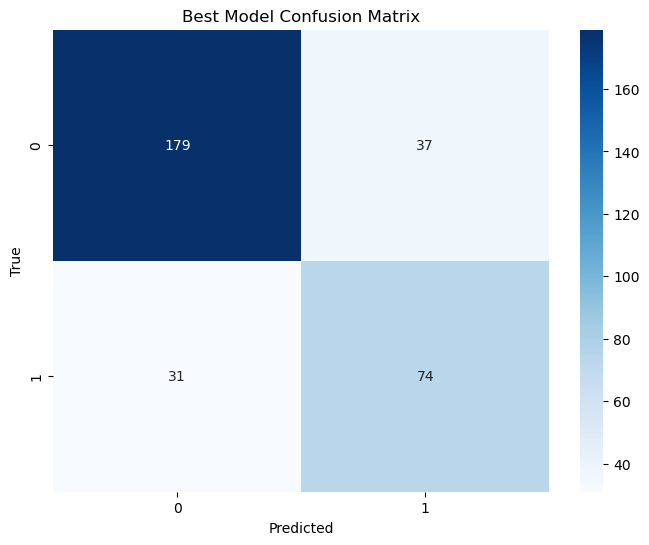

In [5]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm  # TQDM import
import torch.nn as nn
from collections import Counter
from sklearn.metrics import confusion_matrix  # 혼동 행렬을 위한 import
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []
        
        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

# 경로 및 배치 크기 설정
data_dir = "."
batch_size = 64

# 데이터 증강 포함한 이미지 전처리
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),  # 더 큰 회전 각도
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이미지 이동
    T.GaussianBlur(kernel_size=3),  # Gaussian Blur 추가
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 학습 및 검증 데이터셋 생성
train_dataset = CustomDataset(os.path.join(data_dir, 'train'), transform=transform)
valid_dataset = CustomDataset(os.path.join(data_dir, 'valid'), transform=transform)

# 각 클래스의 데이터 개수 계산 (Counter 사용)
class_counts = Counter([label for _, label in train_dataset])

# 클래스별로 가중치를 부여 (데이터 개수의 역수 사용)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# 각 샘플의 가중치를 리스트로 변환
sample_weights = [class_weights[label] for _, label in train_dataset]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

# WeightedRandomSampler를 적용한 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 사전 학습된 SqueezeNet 모델 사용
from torchvision.models import SqueezeNet1_0_Weights

weights = SqueezeNet1_0_Weights.DEFAULT
model = models.squeezenet1_0(weights=weights)

# 모든 레이어 학습 가능하도록 설정 (전이 학습 제외)
for param in model.parameters():
    param.requires_grad = True

# 출력 레이어를 분류하려는 클래스 수에 맞게 수정 (드롭아웃 비율 0.5로 설정)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Dropout 비율을 0.5로 증가
    nn.Conv2d(512, len(train_dataset.classes), kernel_size=(1, 1), stride=(1, 1)),
    nn.AdaptiveAvgPool2d((1, 1))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping 설정
best_accuracy = 0
best_cm = None  # 베스트 모델일 때 혼동 행렬 저장
patience = 30  # 개선되지 않는 에포크를 허용하는 최대 수
counter = 0

# 손실 함수 및 AdamW 옵티마이저 설정 (학습률 0.00005로 감소, 가중치 감쇠 0.1로 증가)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

# 학습률 스케줄러 추가 (학습률 점진적 감소, gamma=0.5, step_size=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 과정 (TQDM으로 진행 상황 시각화, 에포크 30)
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # TQDM으로 학습 진행 표시
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in train_loader_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader_iter.set_postfix(loss=running_loss / len(train_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 평가
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())  # 실제 라벨 저장
            all_preds.extend(predicted.cpu().numpy())  # 예측 라벨 저장

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy}%')

    # Early Stopping 기준
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        counter = 0  # 성능 개선 시 카운터 초기화
        torch.save(model.state_dict(), 'best_model.pth')  # 최적의 모델 저장

        # 베스트 모델일 때 혼동 행렬 계산 및 저장
        best_cm = confusion_matrix(all_labels, all_preds)

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping 적용")
            break

# 베스트 모델의 혼동 행렬 시각화
if best_cm is not None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Best Model Confusion Matrix')
    plt.show()


In [ ]:
옵티마이저 - 소피아
옵티마이저 - sharpeness aware minimization

vision XAI - grad CAM